<a href="https://colab.research.google.com/github/timonpalm/TFCourse/blob/main/05_transfer_learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning: Fine-Tuning

In [1]:
! nvidia-smi

Mon Nov 20 07:43:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# ! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-11-20 07:43:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-20 07:43:12 (48.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# import helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

In [4]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip_data("10_food_classes_10_percent.zip")

--2023-11-20 07:43:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.114.207, 172.253.119.207, 142.250.1.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.114.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   176MB/s    in 0.9s    

2023-11-20 07:43:22 (176 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE
                                                                )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.84683670e+02 1.25683670e+02 9.68367290e+00]
   [1.86382660e+02 1.27382652e+02 7.52551079e+00]
   [1.93209183e+02 1.35209183e+02 1.12193871e+01]
   ...
   [2.27321335e+02 1.68545822e+02 4.44693680e+01]
   [2.23989838e+02 1.66678619e+02 6.16277199e+01]
   [2.24857071e+02 1.67959122e+02 8.18011169e+01]]

  [[1.80311234e+02 1.21311226e+02 5.31122446e+00]
   [1.87780624e+02 1.28780624e+02 8.92346954e+00]
   [1.91255096e+02 1.33255096e+02 9.82653046e+00]
   ...
   [1.98831451e+02 1.42530457e+02 3.17754803e+01]
   [2.27954117e+02 1.72954117e+02 8.18929977e+01]
   [2.24622314e+02 1.69239731e+02 9.49082031e+01]]

  [[1.81214279e+02 1.20214287e+02 5.21428585e+00]
   [1.82928574e+02 1.22857147e+02 3.07142830e+00]
   [1.87765305e+02 1.27765312e+02 5.33673477e+00]
   ...
   [2.10383438e+02 1.54215118e+02 5.91233978e+01]
   [2.23892960e+02 1.70693985e+02 9.40920410e+01]
   [2.30264755e+02 1.79341293e+02 1.15484215e+02]]

  ...

  [[1.22362190e+02 8.34999313e+01 5.49997807e+00]
   [1

# Using tf.keras.Sequential

In [11]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    #classes=10,
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    pooling="avg"
    )
base_model.trainable = False # don't train base_model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

24274472/24274472 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [13]:
history1 = model.fit(train_data_10_percent,
          steps_per_epoch=len(train_data_10_percent),
          epochs=5,
          validation_data=test_data,
          validation_steps=len(test_data),
          callbacks=[create_tensorboard_callback("model_hub", "effnet_sequ")])

Saving TensorBoard log files to: model_hub/effnet_sequ/20231120-074343
Epoch 1/5
24/24 [==============================] - 37s 666ms/step - loss: 1.8893 - accuracy: 0.4133 - val_loss: 1.3376 - val_accuracy: 0.7164
Epoch 2/5
24/24 [==============================] - 12s 483ms/step - loss: 1.1586 - accuracy: 0.7493 - val_loss: 0.9093 - val_accuracy: 0.8060
Epoch 3/5
24/24 [==============================] - 13s 529ms/step - loss: 0.8472 - accuracy: 0.8187 - val_loss: 0.7246 - val_accuracy: 0.8312
Epoch 4/5
24/24 [==============================] - 10s 417ms/step - loss: 0.7019 - accuracy: 0.8413 - val_loss: 0.6316 - val_accuracy: 0.8456
Epoch 5/5
24/24 [==============================] - 13s 529ms/step - loss: 0.6045 - accuracy: 0.8707 - val_loss: 0.5707 - val_accuracy: 0.8592


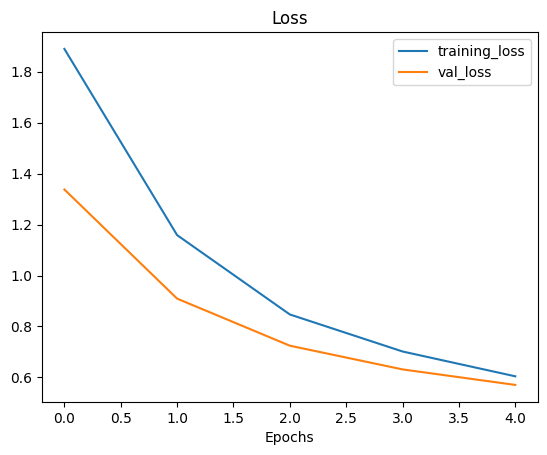

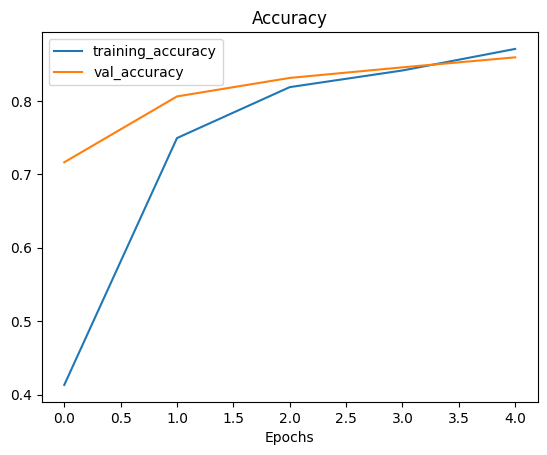

In [14]:
plot_loss_curves(history1)

# Using Functional API

In [15]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    #classes=10,
    #input_shape=IMG_SIZE + (3,),
    include_top=False,
    #pooling="max"
    )

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name="input_layer")

# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="globalPooling")(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

In [16]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("model_hub", "effnet_func")])

Saving TensorBoard log files to: model_hub/effnet_func/20231120-074525
Epoch 1/5
24/24 [==============================] - 33s 612ms/step - loss: 1.9510 - accuracy: 0.3413 - val_loss: 1.3713 - val_accuracy: 0.7176
Epoch 2/5
24/24 [==============================] - 12s 487ms/step - loss: 1.1739 - accuracy: 0.7427 - val_loss: 0.9127 - val_accuracy: 0.8104
Epoch 3/5
24/24 [==============================] - 13s 528ms/step - loss: 0.8599 - accuracy: 0.8067 - val_loss: 0.7265 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 7s 279ms/step - loss: 0.7058 - accuracy: 0.8573 - val_loss: 0.6319 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 9s 358ms/step - loss: 0.6050 - accuracy: 0.8627 - val_loss: 0.5708 - val_accuracy: 0.8572


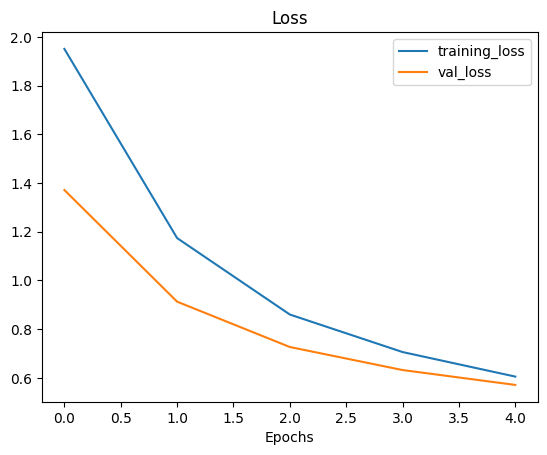

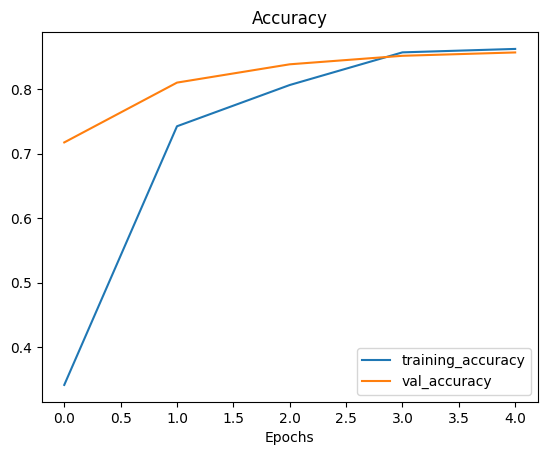

In [17]:
plot_loss_curves(history_1)

# Only using 1 % of the data

In [18]:
# ! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# unzip_data("10_food_classes_1_percent.zip")

--2023-11-20 07:46:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.207, 173.194.196.207, 173.194.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   109MB/s    in 1.2s    

2023-11-20 07:46:45 (109 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [19]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'

In [20]:
train_dir = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE,
                                                                           label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [22]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(include_top=False)

base_model.trainable = False

input = tf.keras.layers.Input(shape=IMG_SIZE + (3,))

x = base_model(input)

x = tf.keras.layers.GlobalAveragePooling2D(name="globalPooling")(x)

output = tf.keras.layers.Dense(10, activation="softmax")(x)

model_2 = tf.keras.Model(inputs=input, outputs=output)

28456008/28456008 [==============================] - 0s 0us/step


In [23]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"])

In [24]:
history_2 = model_2.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("model_hub", "eff_1_percent")])

Saving TensorBoard log files to: model_hub/eff_1_percent/20231120-074654
Epoch 1/5
3/3 [==============================] - 20s 5s/step - loss: 2.3906 - accuracy: 0.0286 - val_loss: 2.1611 - val_accuracy: 0.1936
Epoch 2/5
3/3 [==============================] - 6s 3s/step - loss: 2.0646 - accuracy: 0.2571 - val_loss: 2.0073 - val_accuracy: 0.3560
Epoch 3/5
3/3 [==============================] - 11s 5s/step - loss: 1.8554 - accuracy: 0.3857 - val_loss: 1.8764 - val_accuracy: 0.4708
Epoch 4/5
3/3 [==============================] - 10s 5s/step - loss: 1.6763 - accuracy: 0.6286 - val_loss: 1.7586 - val_accuracy: 0.5568
Epoch 5/5
3/3 [==============================] - 9s 4s/step - loss: 1.4511 - accuracy: 0.7286 - val_loss: 1.6561 - val_accuracy: 0.6032


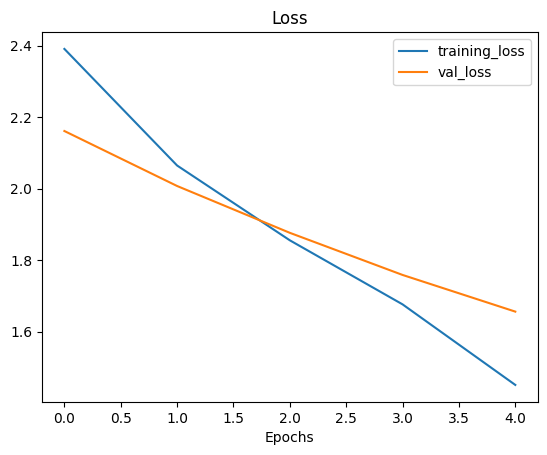

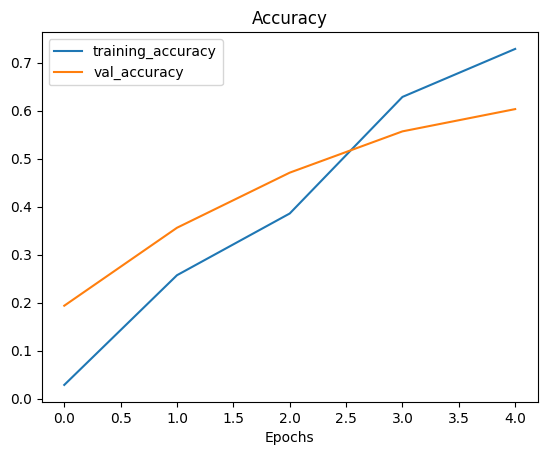

In [31]:
plot_loss_curves(history_2)

In [32]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [47]:
from tensorflow.keras.layers.experimental import preprocessing

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(include_top=False)
base_model.trainable = False

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomContrast(factor=0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescaling(1./255),
], name="data_augmentation")

input = tf.keras.layers.Input(shape=IMG_SIZE + (3,))

x = data_augmentation(input, training=False)

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D(name="globalPooling")(x)

output = tf.keras.layers.Dense(10, activation="softmax")(x)

model_3 = tf.keras.Model(inputs=input, outputs=output)

In [34]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"])

In [35]:
history_3 = model_3.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("model_hub", "eff_10_percent"),
                                   checkpoint_callback])

Saving TensorBoard log files to: model_hub/eff_10_percent/20231120-074940
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.8100 - accuracy: 0.4413
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checpoint.ckpt
24/24 [==============================] - 20s 433ms/step - loss: 1.8100 - accuracy: 0.4413 - val_loss: 1.2539 - val_accuracy: 0.7376
Epoch 2/5
23/24 [===========================>..] - ETA: 0s - loss: 1.0316 - accuracy: 0.7704
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checpoint.ckpt
24/24 [==============================] - 10s 380ms/step - loss: 1.0299 - accuracy: 0.7733 - val_loss: 0.8298 - val_accuracy: 0.8208
Epoch 3/5
23/24 [===========================>..] - ETA: 0s - loss: 0.7321 - accuracy: 0.8329
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checpoint.ckpt
24/24 [==============================] - 9s 382ms/step - loss: 0.7342 - accuracy: 0.8320 - val_loss: 0.6660 - val_accuracy: 0.8452
Epoch 4/5
23/24 [=

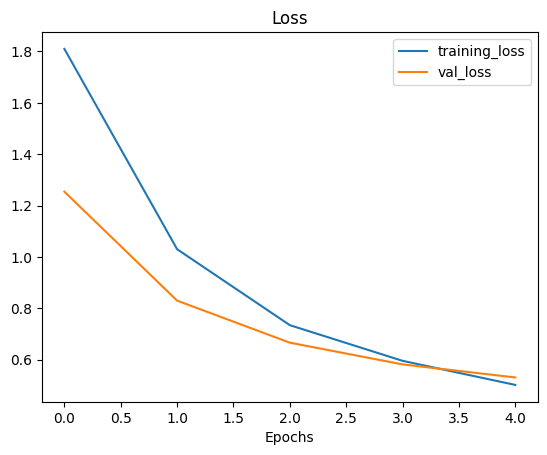

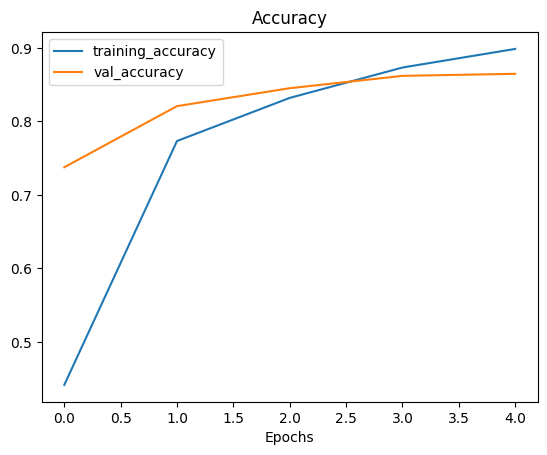

In [36]:
plot_loss_curves(history_3)

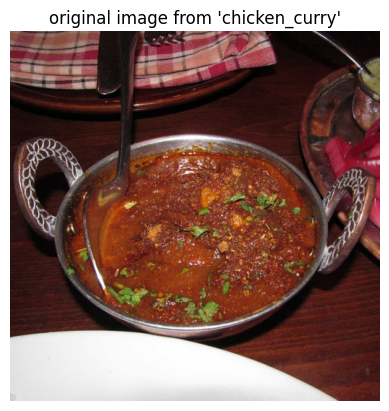

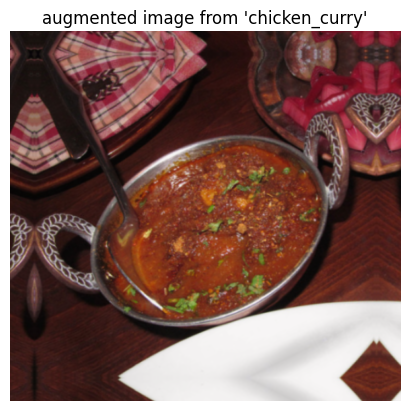

In [29]:
# view a random image and compare it to its augmented image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class =  random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)

plt.title(f"original image from '{target_class}'")
plt.axis(False)
plt.imshow(img)

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.title(f"augmented image from '{target_class}'")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_img/255))

In [37]:
model_3.load_weights(checkpoint_path)

In [38]:
results = model_3.evaluate(test_data)

79/79 [==============================] - 8s 87ms/step - loss: 0.5306 - accuracy: 0.8648


# Model 4

In [43]:
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# base_model.trainable = False

# input = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name="input")

# x = base_model(input, training=False)

# x = tf.keras.layers.GlobalAveragePooling2D(name="GlobalPooling")(x)

# output = tf.keras.layers.Dense(10, activation="softmax")(x)

# model_4 = tf.keras.Model(inputs=input, outputs=output)

In [44]:
for layer in model_3.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7a7b542869b0> True
<keras.src.engine.sequential.Sequential object at 0x7a7b4ccdafb0> True
<keras.src.engine.functional.Functional object at 0x7a7b4ccdb640> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7a7c3d820460> True
<keras.src.layers.core.dense.Dense object at 0x7a7b4cb63f40> True


In [ ]:
for i,layer in enumerate(model_3.layers[2].layers):
  print(i, layer.name, layer.trainable)

In [54]:
base_model.trainable = False

for layer in base_model.layers[-10:]:
  layer.trainable = True

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"])

In [ ]:
for i,layer in enumerate(model_3.layers[2].layers):
  print(i, layer.name, layer.trainable)

In [56]:
history_4 = model_3.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("model_hub", "eff_10_percent"),
                                   checkpoint_callback])

Saving TensorBoard log files to: model_hub/eff_10_percent/20231120-082105
Epoch 1/5
23/24 [===========================>..] - ETA: 0s - loss: 0.4485 - accuracy: 0.9103
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checpoint.ckpt
24/24 [==============================] - 21s 479ms/step - loss: 0.4466 - accuracy: 0.9107 - val_loss: 0.5140 - val_accuracy: 0.8776
Epoch 2/5
23/24 [===========================>..] - ETA: 0s - loss: 0.4355 - accuracy: 0.9158
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checpoint.ckpt
24/24 [==============================] - 13s 533ms/step - loss: 0.4353 - accuracy: 0.9147 - val_loss: 0.5077 - val_accuracy: 0.8788
Epoch 3/5
23/24 [===========================>..] - ETA: 0s - loss: 0.4266 - accuracy: 0.9171
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checpoint.ckpt
24/24 [==============================] - 14s 565ms/step - loss: 0.4263 - accuracy: 0.9173 - val_loss: 0.5025 - val_accuracy: 0.8784
Epoch 4/5
23/24 [

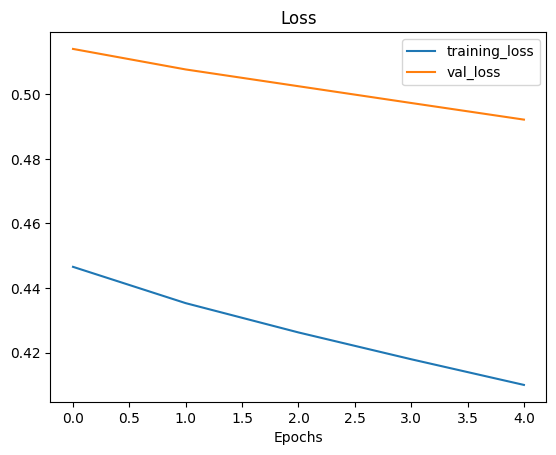

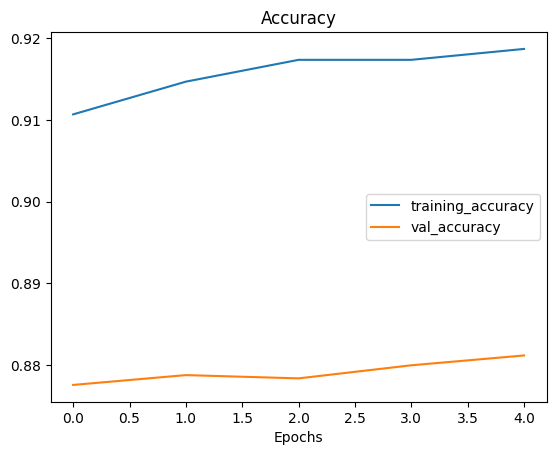

In [57]:
plot_loss_curves(history_4)

In [58]:
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2023-11-20 08:34:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.207, 64.233.181.207, 64.233.182.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  58.9MB/s    in 7.6s    

2023-11-20 08:34:51 (64.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [59]:
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [60]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 

In [61]:
IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 batch_size=32,
                                                                  label_mode="categorical",
                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                batch_size=32,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [65]:
model_3.load_weights(checkpoint_path)
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"])

In [66]:
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("model_hub", "big_model"),
                                   checkpoint_callback])

Saving TensorBoard log files to: model_hub/big_model/20231120-084431
Epoch 1/5
235/235 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8545
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checpoint.ckpt
235/235 [==============================] - 39s 118ms/step - loss: 0.4773 - accuracy: 0.8545 - val_loss: 0.3215 - val_accuracy: 0.9084
Epoch 2/5
234/235 [============================>.] - ETA: 0s - loss: 0.3714 - accuracy: 0.8851
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checpoint.ckpt
235/235 [==============================] - 26s 108ms/step - loss: 0.3710 - accuracy: 0.8853 - val_loss: 0.2915 - val_accuracy: 0.9140
Epoch 3/5
234/235 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.9009
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checpoint.ckpt
235/235 [==============================] - 31s 132ms/step - loss: 0.3235 - accuracy: 0.9011 - val_loss: 0.2770 - val_accuracy: 0.9136
Epoch 4/5


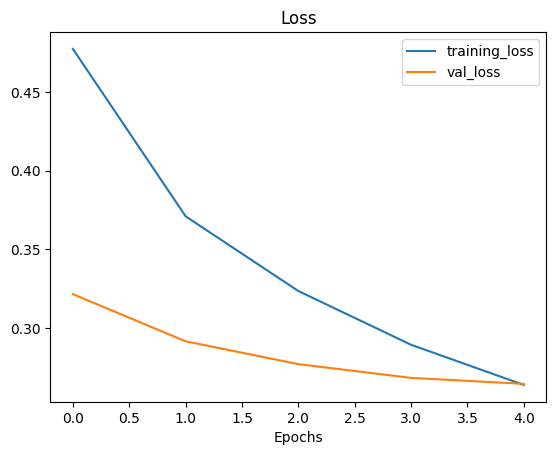

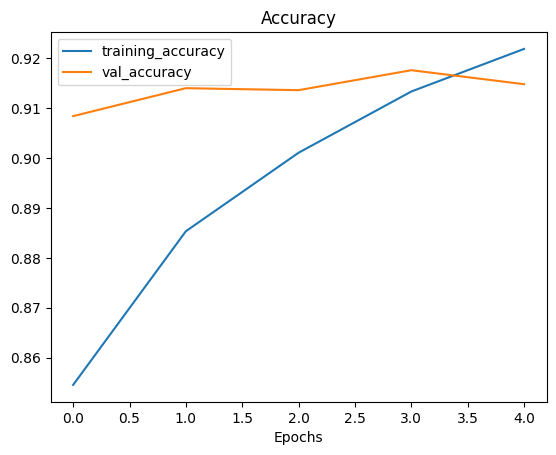

In [67]:
plot_loss_curves(history_3)